In [12]:
import pandas as pd
import torch
from transformers import (
    DPRQuestionEncoder, DPRQuestionEncoderTokenizer,
    DPRContextEncoder, DPRContextEncoderTokenizer
)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

PHASE 1 - DATASET LOADING

A 30K sample in the format of (query,positive passage,negative passage) is retrieved from the original dataset 'triples.train.small.tsv'

In [5]:
####### DO NOT USE THIS DATASET ########
####### USE: qidpidtriples.top3.clean.tsv ########
file_path = r"qidpidtriples.top3.clean.tsv"

df = pd.read_csv(
    file_path,
    sep='\t',
    header=None,
    names=["query", "positive", "negative"],
    encoding='utf-16',         
)
df.shape

(29999, 3)

PHASE 2 - TRAIN-TEST SPLIT

Split into train set (80%) and test set (20%)

In [ ]:

# Convert to Hugging Face Dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df)

print(train_dataset[0])


{'query': 'another name for the primary visual cortex is', 'positive': 'the primary (parts of the cortex that receive sensory inputs from the thalamus) visual cortex is also known as v1, v isual area one, and the striate cortex.the extrastriate areas consist of visual areas two (v2), three (v3), four (v4), and five (v5).he primary visual cortex is the best-studied visual area in the brain. in all mammals studied, it is located in the posterior pole of the occipital cortex (the occipital cortex is responsible for processing visual stimuli).', 'negative': 'the frontal lobe of the brain. the frontal lobe is concerned with executing behavior. this ranges from the control of individual muscles in the primary motor cortex to high level abstract planning about what to do.hese lobes are further divided into different regions. the frontal lobes are involved with control of movement, from stimulation of individual muscles to abstract planning about what to do. the parietal lobe processes visual,

PHASE 3: TRAINING STAGE

1. The first step is to load the question and context encoders of the DPR model

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# Question encoder
question_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(DEVICE)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

# Context encoder
context_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base").to(DEVICE)
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

cuda


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the

2. Creation of the dataset class

In [6]:
class DPRDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.data = hf_dataset
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data[idx]  
        return {
            "query": row["query"],
            "positive_passage": row["positive"],
            "negative_passage": row["negative"]
        }

train_dpr_dataset = DPRDataset(train_dataset)

print(len(train_dpr_dataset))
print(train_dpr_dataset[0])

29999
{'query': 'another name for the primary visual cortex is', 'positive_passage': 'the primary (parts of the cortex that receive sensory inputs from the thalamus) visual cortex is also known as v1, v isual area one, and the striate cortex.the extrastriate areas consist of visual areas two (v2), three (v3), four (v4), and five (v5).he primary visual cortex is the best-studied visual area in the brain. in all mammals studied, it is located in the posterior pole of the occipital cortex (the occipital cortex is responsible for processing visual stimuli).', 'negative_passage': 'the frontal lobe of the brain. the frontal lobe is concerned with executing behavior. this ranges from the control of individual muscles in the primary motor cortex to high level abstract planning about what to do.hese lobes are further divided into different regions. the frontal lobes are involved with control of movement, from stimulation of individual muscles to abstract planning about what to do. the parietal 

3. Definition of the collate_fn() function

In [7]:
import torch
from torch.utils.data import DataLoader

# Hyperparameters
BATCH_SIZE  = 16
Q_MAX_LEN   = 64
CTX_MAX_LEN = 256

# Collate function for batching and tokenization
def collate_fn(batch):
    queries   = [b["query"] for b in batch]
    positives = [b["positive_passage"] for b in batch]
    negatives = [b["negative_passage"] for b in batch]

    # Tokenize queries
    q_enc = question_tokenizer(
        queries, padding=True, truncation=True, max_length=Q_MAX_LEN,
        pad_to_multiple_of=8, return_tensors="pt"
    )

    # Tokenize passages (positives + negatives)
    ctx_enc = context_tokenizer(
        positives + negatives, padding=True, truncation=True, max_length=CTX_MAX_LEN,
        pad_to_multiple_of=8, return_tensors="pt"
    )

    return q_enc, ctx_enc

train_dpr_dataset = DPRDataset(train_dataset)

train_loader = DataLoader(
    train_dpr_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

# NaN diagnostics on encoder outputs (robust w/o torch.nanmax)
with torch.no_grad():
    for i, (q_enc, ctx_enc) in enumerate(train_loader):
        q_enc  = {k: v.to(DEVICE) for k, v in q_enc.items()}
        ctx_enc = {k: v.to(DEVICE) for k, v in ctx_enc.items()}

        q_out  = question_encoder(**q_enc).pooler_output          # [B, H]
        ctx_out = context_encoder(**ctx_enc).pooler_output        # [2B, H]
        p_out, n_out = ctx_out.split(q_out.size(0), dim=0)

        def report(name, t):
            has_nan = torch.isnan(t).any()
            finite = t[torch.isfinite(t)]
            max_abs = finite.abs().max().item() if finite.numel() else float('nan')
            if has_nan:
                bad_rows = torch.isnan(t).any(dim=1).nonzero(as_tuple=True)[0]
                print(f"{name}: FOUND NaNs  count={torch.isnan(t).sum().item()}  rows={bad_rows.tolist()}  max|finite|={max_abs:.4f}")
            else:
                print(f"{name}: OK (no NaNs)  max|val|={max_abs:.4f}")
            return has_nan

        print(f"\nBatch {i}")
        q_nan = report("q_out", q_out)
        p_nan = report("p_out", p_out)
        n_nan = report("n_out", n_out)

        if q_nan or p_nan or n_nan:
            if q_nan:
                bad_q_idx = torch.isnan(q_out).any(dim=1).nonzero(as_tuple=True)[0].tolist()
                print("\nProblematic queries:")
                for j in bad_q_idx:
                    ds_idx = i * BATCH_SIZE + j
                    print(f"[dataset idx {ds_idx}] {train_dpr_dataset[ds_idx]['query']}")
            if p_nan or n_nan:
                print("NaNs found in passage encodings.")
            break

        if i == 4:
            break



Batch 0
q_out: OK (no NaNs)  max|val|=7.2684
p_out: OK (no NaNs)  max|val|=5.9730
n_out: OK (no NaNs)  max|val|=6.2854

Batch 1
q_out: OK (no NaNs)  max|val|=7.2483
p_out: OK (no NaNs)  max|val|=5.9922
n_out: OK (no NaNs)  max|val|=6.2433

Batch 2
q_out: OK (no NaNs)  max|val|=7.2784
p_out: OK (no NaNs)  max|val|=6.1362
n_out: OK (no NaNs)  max|val|=6.1528

Batch 3
q_out: OK (no NaNs)  max|val|=7.3192
p_out: OK (no NaNs)  max|val|=6.1601
n_out: OK (no NaNs)  max|val|=6.0715

Batch 4
q_out: OK (no NaNs)  max|val|=7.2450
p_out: OK (no NaNs)  max|val|=6.1880
n_out: OK (no NaNs)  max|val|=6.3587


Training loop

/tmp/ipykernel_1817/2340112763.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_1817/2340112763.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 1/3  Loss: 0.2003
Epoch 2/3  Loss: 0.1997
Epoch 3/3  Loss: 0.2003


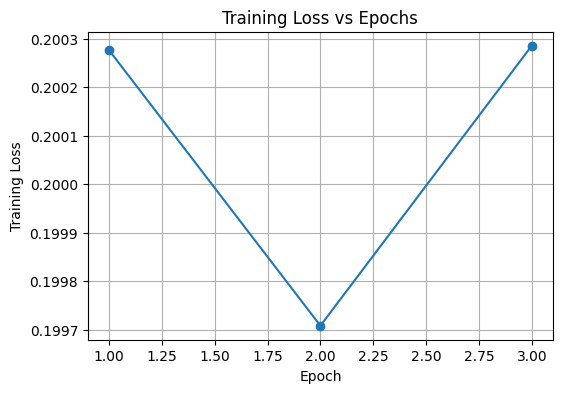

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

EPOCHS = 3
LEARNING_RATE = 0.001

optimizer = torch.optim.AdamW(list(question_encoder.parameters()) + list(context_encoder.parameters()),
                              lr=LEARNING_RATE)

scaler = GradScaler(enabled=torch.cuda.is_available())
epoch_losses = []

question_encoder.train()
context_encoder.train()

for epoch in range(EPOCHS):
    total_loss = 0.0

    for q_enc, ctx_enc in train_loader:
        optimizer.zero_grad()

        # -------Move batch to GPU
        q_enc   = {k: v.to(DEVICE, non_blocking=True) for k,v in q_enc.items()}
        ctx_enc = {k: v.to(DEVICE, non_blocking=True) for k,v in ctx_enc.items()}

        B = q_enc["input_ids"].size(0)

        # -------Forward pass with mixed precision
        with autocast(enabled=torch.cuda.is_available()):
            q_out   = question_encoder(**q_enc).pooler_output  # [B, H]
            ctx_out = context_encoder(**ctx_enc).pooler_output  # [2B, H]
            p_out, n_out = ctx_out.split(B, dim=0)

            # -------Cosine margin loss
            pos = torch.cosine_similarity(q_out, p_out, dim=1)
            neg = torch.cosine_similarity(q_out, n_out, dim=1)
            loss = (0.2 - pos + neg).clamp_min_(0).mean()

        # -------Backward + optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {avg_loss:.4f}")

plt.figure(figsize=(6,4))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()

Model saving

In [9]:
question_encoder.save_pretrained("./dpr_question_encoder")
context_encoder.save_pretrained("./dpr_context_encoder")
question_tokenizer.save_pretrained("./dpr_question_encoder")
context_tokenizer.save_pretrained("./dpr_context_encoder")

print("Training complete and models saved!")

Training complete and models saved!


Collect all passages for FAISS

In [14]:
import pandas as pd

# -------Load collection
collection = pd.read_csv("common_dataset.tsv", sep="\t", names=["pid", "text"], dtype={"pid": str, "text": str})


print(len(collection))  # -------smaller than full 8.8M

30000


In [15]:
import torch
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

context_encoder.eval()
context_encoder.to(DEVICE)

# ----------------------------------------------
# Multi-process pre-tokenization with HuggingFace Datasets
# ----------------------------------------------
# Create a HF Dataset containing only the passage text column
raw_ds = Dataset.from_pandas(collection[["text"]])

# Tokenization function (returns dict of model inputs)
def tok(batch):
    return context_tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",   # fixed length => tensorize easily
        max_length=256,
    )

# Map with multiprocessing (adjust num_proc to available CPU cores)
# remove original text column to save memory
print("Tokenizing passages (multi-process)...")
tok_ds = raw_ds.map(
    tok,
    batched=True,
    batch_size=512,
    num_proc=4,          # change if you have fewer cores
    remove_columns=["text"],
    desc="Tokenizing"
)

# Set PyTorch format for direct tensor access
Tok_COLUMNS = [c for c in ["input_ids", "attention_mask", "token_type_ids"] if c in tok_ds.column_names]
tok_ds.set_format(type="torch", columns=Tok_COLUMNS)

# DataLoader to stream batches to the encoder (no need for workers now; already tokenized)
EMB_BATCH_SIZE = 64  # tune based on GPU memory
passage_loader = DataLoader(tok_ds, batch_size=EMB_BATCH_SIZE, shuffle=False)

passage_embeddings = []
print("Encoding passages...")
with torch.no_grad():
    for batch in tqdm(passage_loader, desc="Encoding"):
        batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
        emb = context_encoder(**batch).pooler_output  # [B, H]
        passage_embeddings.append(emb.cpu())

# Concatenate all batches
passage_embeddings = torch.cat(passage_embeddings, dim=0).numpy()
print("Passage embeddings shape:", passage_embeddings.shape)

Tokenizing passages (multi-process)...


Setting TOKENIZERS_PARALLELISM=false for forked processes.
Tokenizing (num_proc=4):   0%|          | 0/30000 [00:00<?, ? examples/s]

Tokenizing (num_proc=4): 100%|██████████| 30000/30000 [00:17<00:00, 1742.69 examples/s]



Encoding passages...


Encoding: 100%|██████████| 469/469 [07:02<00:00,  1.11it/s]

Passage embeddings shape: (30000, 768)


Save embeddings

In [16]:
import numpy as np

# Save
np.save("passage_embeddings.npy", passage_embeddings)

# Load later
loaded_embeddings = np.load("passage_embeddings.npy")
print(loaded_embeddings.shape)

(30000, 768)


Build FAISS Index

In [13]:
import faiss
dim = passage_embeddings.shape[1]  # typically 768 for DPR
index = faiss.IndexFlatIP(dim)
index.add(passage_embeddings)

print("Number of vectors in FAISS:", index.ntotal)

Number of vectors in FAISS: 516472


In [25]:
import torch
import numpy as np
import faiss
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. -------Load trained DPR encoders + tokenizers
question_encoder = DPRQuestionEncoder.from_pretrained("./dpr_question_encoder").to(DEVICE)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("./dpr_question_encoder")

# 2. -------Load FAISS index + passage list
passage_embeddings = np.load("passage_embeddings.npy")   # embeddings
collection = pd.read_csv("common_dataset.tsv", sep="\t", names=["pid", "text"], dtype={"pid": str, "text": str})

dim = passage_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
faiss.normalize_L2(passage_embeddings)   # normalize before adding
index.add(passage_embeddings)

print("FAISS index size:", index.ntotal)

# 3. -------Pick your query from test set
query_text = "what temperature should you reheat lasagna to"

# -------Find the ground-truth positive from test set
true_passages = collection["text"].tolist()

# 4. -------Encode query
inputs = question_tokenizer(query_text, return_tensors="pt", truncation=True, padding=True, max_length=64).to(DEVICE)
with torch.no_grad():
    q_emb = question_encoder(**inputs).pooler_output.cpu().numpy()
    faiss.normalize_L2(q_emb)

# 5. -------Search FAISS
top_k = 5
D, I = index.search(q_emb, top_k)
retrieved = [true_passages[i] for i in I[0]]

# 6. -------Show results
print(f"\n Query: {query_text}\n")

# print(" Ground-truth positive passage(s):")
# for p in true_passages:
#     print("-", p, "\n")

print(f"Top-{top_k} Retrieved Passages:")
for rank, passage in enumerate(retrieved, 1):
    print(f"{rank}. {passage}\n")

FAISS index size: 30000

 Query: what temperature should you reheat lasagna to

Top-5 Retrieved Passages:
1. April 19, 2017, 2:54:59 PM EDT. President Trump signed a bill into law on Tuesday that will improve forecasting and researching capabilities across the American weather industry and better protect the public from extreme weather. more.

2. According to PLUS, The term 'Plus Size' is an industry standard that applies to any women who is over a size 12. To be even more specific, the fashion industry identifies plus size as sizes 12-24, super size as sizes 4X-6X and extended size as 7X and up. We reached out for another point of view to Susan Barone, owner of the curvy online store, Alwaysforme.com.

3. President Herbert Hoover 31st President Herbert Hoover, a member of the Republican Party, took office as the 31st President of the United States on March 4, 1929 at age 54. Hoover served in office for 4 years and left when he lost reelection. He was born in West Branch, IA and receiv

METRICS

In [39]:
import numpy as np
import torch
import faiss
from tqdm import tqdm
from sklearn.metrics import ndcg_score
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
import pandas as pd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# Load trained DPR Question Encoder
# ----------------------------
question_encoder = DPRQuestionEncoder.from_pretrained("./dpr_question_encoder").to(DEVICE)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("./dpr_question_encoder")

# Load FAISS index and passages
index = faiss.IndexFlatIP(np.load("passage_embeddings.npy").shape[1])  
passage_embeddings = np.load("passage_embeddings.npy")
index.add(passage_embeddings)

all_passages = collection["text"].tolist()

# ----------------------------
# Metrics Computation
# ----------------------------
def evaluate(eval_df: pd.DataFrame, top_k=10, batch_size=32):
    """
    Evaluate retrieval metrics (Precision@k, MAP, nDCG@k).
    Expects eval_df with columns: qid, query, text (each (qid, query) may have multiple positive texts).
    """
    # Group positives per query (set of relevant passages)
    grouped = (eval_df.groupby(["qid", "query"])["text"]
                      .apply(lambda s: {t.strip() for t in s})
                      .reset_index())

    queries_list = grouped["query"].tolist()
    relevant_sets = grouped["text"].tolist()

    precision_scores = []
    ap_scores = []
    ndcg_scores = []

    for start in tqdm(range(0, len(queries_list), batch_size), desc="Evaluating"):
        batch_queries = queries_list[start:start + batch_size]

        enc = question_tokenizer(
            batch_queries,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=64
        ).to(DEVICE)

        with torch.no_grad():
            q_emb = question_encoder(**enc).pooler_output  # (B, dim)

        q_emb = torch.nn.functional.normalize(q_emb, p=2, dim=1)

        D, I = index.search(q_emb.cpu().numpy(), top_k)  # (B, top_k)

        for b in range(len(batch_queries)):
            retrieved_texts = [all_passages[idx] for idx in I[b]]
            rel_set = relevant_sets[start + b]

            labels = [1 if passage.strip() in rel_set else 0 for passage in retrieved_texts]

            # Precision@k
            precision_scores.append(sum(labels) / top_k)

            # Average Precision
            if sum(labels) > 0:
                precisions_at_hits = [
                    sum(labels[:i + 1]) / (i + 1)
                    for i, lbl in enumerate(labels) if lbl == 1
                ]
                ap = float(np.mean(precisions_at_hits))
            else:
                ap = 0.0
            ap_scores.append(ap)

            # nDCG@k (binary relevance)
            relevance = np.asarray([labels])
            scores = np.asarray([D[b]])
            ndcg_scores.append(ndcg_score(relevance, scores, k=top_k))

    return {
        f"Precision@{top_k}": float(np.mean(precision_scores)),
        "MAP": float(np.mean(ap_scores)),
        f"nDCG@{top_k}": float(np.mean(ndcg_scores)),
        "num_queries": len(queries_list)
    }
# ----------------------------

# ----------------------------
# Run evaluation
# ----------------------------
queries = pd.read_csv("queries.dev.tsv", sep="\t", names=["qid", "query"], dtype={"qid": str, "query": str})
qrels = pd.read_csv("qrels.dev.tsv", sep="\t", names=["qid","_","pid","rel"], dtype={"qid":str,"pid":str,"rel":int})
filtered_qrels = qrels[qrels['pid'].isin(collection['pid'])]
queries_eval = (queries[queries['qid'].isin(filtered_qrels['qid'])]
                .drop_duplicates('qid')
                [['qid','query']])

qrels_for_eval = filtered_qrels[['qid','pid','rel']].astype({"qid":str,"pid":str,"rel":int})
sampled_queries = queries_eval.sample(n=1000, random_state=42)

eval_df = sampled_queries.merge(qrels_for_eval, on=["qid"], how="inner").merge(collection,
 on=["pid"], how="inner").astype({'query': str, 'text': str})

metrics = evaluate(eval_df, top_k=10)
print(metrics)

Evaluating: 100%|██████████| 32/32 [00:03<00:00,  8.69it/s]

{'Precision@10': 0.0, 'MAP': 0.0, 'nDCG@10': 0.0, 'num_queries': 1000}
